<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/Seq_JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title data
import torch
import torchvision
import torchvision.transforms as transforms
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor(),])

# train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transform) # do not normalise! want img in [0,1)
# test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform) #opt no download
# # batch_size = 32 # 64 512
# batch_size = 32 if torch.cuda.is_available() else 32

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
batch_size = 128 # 4
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# dataiter = iter(train_data)
# x,y = next(dataiter)
# print(x.shape) # [3, 32, 32]

100%|██████████| 170M/170M [00:05<00:00, 28.6MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [2]:
# @title (Learned)RotEmb
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class RoPE(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, seq_len=512, base=10000):
        super().__init__()
        self.dim, self.base = dim, base
        theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
        pos = torch.arange(seq_len).unsqueeze(-1)
        angles = (pos * theta)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
        self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [seq_len, dim // 2, 2] -> [1, seq_len, dim]

    def forward(self, x):
        seq_len = x.size(1)
        if self.rot_emb.shape[0] < seq_len: self.__init__(self.dim, seq_len, self.base)
        return x * self.rot_emb[:seq_len]

# class LearnedRoPE(nn.Module): # learnt RoPE ; each tok is 1 pos
#     def __init__(self, dim):
#         super().__init__()
#         self.weights = nn.Parameter(torch.randn(1, dim//2))

#     def forward(self, x): #
#         batch, seq_len, dim = x.shape
#         # if rot_emb.shape[0] < seq_len: self.__init__(dim, seq_len)
#         pos = torch.arange(seq_len).unsqueeze(1)
#         angles = (self.weights * pos * 2*torch.pi).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
#         rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
#         return x * rot_emb.flatten(-2).unsqueeze(0)


class LearnedRoPE(nn.Module): # learnt RoPE ; each tok is 1 pos
    def __init__(self, dim, seq_len=512):
        super().__init__()
        self.dim = dim
        self.weights = nn.Parameter(torch.randn(1, dim//2))
        pos = torch.arange(seq_len).unsqueeze(1)
        angles = (self.weights * pos * 2*torch.pi)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
        self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [seq_len, dim // 2, 2] -> [1, seq_len, dim]

    def forward(self, x): # [batch, seq_len, dim]
        seq_len = x.size(1)
        if self.rot_emb.shape[0] < seq_len: self.__init__(self.dim, seq_len)
        return x * self.rot_emb[:seq_len]


class RotEmb(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, top=torch.pi, base=10000):
        super().__init__()
        self.theta = top / (base ** (torch.arange(0, dim, step=2, device=device) / dim))
        # self.theta = top / (base ** torch.linspace(0, 1, dim//2, device=device))

    def forward(self, pos): # [batch] in [0,1]
        angles = (pos.unsqueeze(-1) * self.theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return rot_emb.flatten(-2) # [seq_len, dim]

class LearnedRotEmb(nn.Module): # pos in R
    def __init__(self, dim):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((1, dim//2), device=device))

    def forward(self, pos): # [batch] in [0,1]
        angles = (self.weights * pos.unsqueeze(-1) * 2*torch.pi).unsqueeze(-1) # [batch, 1] * [1, dim//2] -> [batch, dim//2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [batch, dim // 2, 2]
        return rot_emb.flatten(-2) # [batch, dim]



In [3]:
# @title Transformer Model
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TransformerModel(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
        super().__init__()
        self.embed = nn.Sequential(
            nn.Linear(in_dim, d_model), #act,
            # nn.Linear(d_model, d_model), act,
        )
        # self.embed = nn.Sequential(nn.Conv1d(in_dim,d_model,7,2,7//2), nn.MaxPool1d(3, 2, 3//2))
        self.pos_encoder = RotEmb(d_model, top=1, base=10000)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid or d_model, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.cls = nn.Parameter(torch.zeros(1,1,d_model)) # randn
        self.lin = nn.Linear(d_model, out_dim or d_model)
        self.norm = nn.LayerNorm(out_dim or d_model)


    def forward(self, src, src_key_padding_mask=None, cls_mask=None, context_indices=None, trg_indices=None): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # if cls_mask != None: src[cls_mask] = self.cls.to(src.dtype)

        src = self.embed(src) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = src.shape
        # src = self.pos_encoder(src)
        if context_indices != None:
            # print(src.shape, context_indices.shape, self.pos_encoder(context_indices).shape) # [2, 88, 32]) torch.Size([88]) torch.Size([88, 32]
            # print(src[0], self.pos_encoder(context_indices)[0])
            src = src * self.pos_encoder(context_indices) # context/predictor # src = src + self.positional_emb[:,context_indices]
            # print(src[0])
        else: src = src * self.pos_encoder(torch.arange(seq, device=device)) # target # src = src + self.positional_emb[:,:seq]
            # print("trans fwd", src.shape, self.pos_encoder(src).shape)

        if trg_indices != None: # [M, num_trg_toks]
            pred_tokens = self.cls * self.pos_encoder(trg_indices) # [M, num_trg_toks, d_model] # pred_tokens = self.cls + self.positional_emb[0,trg_indices]
            pred_tokens = pred_tokens.repeat(batch, 1, 1) # [batch*M, num_trg_toks, d_model]
            # print(pred_tokens.requires_grad)
            src = src.repeat_interleave(trg_indices.shape[0], dim=0) # [batch, seq_len, d_model] -> [batch*M, seq_len, d_model]
            src = torch.cat([src, pred_tokens], dim=1) # [batch*M, seq_len+num_trg_toks, d_model]

        out = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask) # float [seq_len, batch_size, d_model]
        if trg_indices != None:
            # print(out.shape)
            out = out[:,seq:] # [batch*M, num_trg_toks, d_model]
            out = self.lin(out)
        out = self.norm(out)
        return out # [seq_len, batch_size, ntoken]

batch, seq_len, d_model = 4,7,64
in_dim = 3
model = TransformerModel(in_dim, d_model, nhead=8, nlayers=2, dropout=0.).to(device)
x =  torch.rand((batch, seq_len, in_dim), device=device)
out = model(x)
# print(out.shape)
# # print(out)


In [ ]:
# @title SeqJEPA
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema
device = "cuda" if torch.cuda.is_available() else "cpu"


def multiblock(seq, min_s, max_s, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_len = torch.rand(1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_pos = torch.rand(M) * (1 - mask_len) # in (0, 1 - mask_len)
    mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
    indices = torch.arange(seq).unsqueeze(0) # [1, seq]
    target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [M, seq]
    return target_mask


class SeqJEPA(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, num_layers=1, num_classes=10):
        super().__init__()
        if out_dim is None: out_dim = d_model
        act = nn.GELU() # ReLU GELU SiLU
        # self.rot_emb = RotEmb(d_model, top=1, base=10)
        # self.rot_emb = RotEmb(d_model, top=torch.pi, base=10)
        # self.rot_emb = RoPE(d_model, seq_len=1024, base=10)
        # self.rot_emb = LearnedRotEmb(dim)
        self.encode = nn.Sequential(
            nn.Linear(in_dim, d_model), #act,
            # nn.Linear(d_model, d_model), act,
        )
        # self.encode = nn.Sequential(nn.Conv1d(in_dim, d_model,7,2,7//2), nn.MaxPool1d(3, 2, 3//2))
        self.context_encoder = TransformerModel(d_model, d_model, out_dim=out_dim, nhead=4, nlayers=2, dropout=0.)
        self.predicter = TransformerModel(out_dim, d_model//2, out_dim, nhead=4, nlayers=1, dropout=0.)
        self.target_encoder = AveragedModel(self.context_encoder, multi_avg_fn=get_ema_multi_avg_fn(0.85)) # 0.95 0.999
        self.target_encoder.requires_grad_(False)
        # self.classifier = nn.Linear(out_dim, num_classes)

    def loss(self, x): # [batch, T, 3]
        x = self.encode(x) # [batch, T, d_model]
        # x = self.encode(x.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]

        batch, seq, dim = x.shape
        M=1 # 4
        # target_mask = multiblock(seq, min_s=0.15, max_s=0.2, M=M) # mask out targets to be predicted # [M, seq]
        target_mask = multiblock(seq, min_s=0.15, max_s=0.2, M=4)#.any(0) # mask out targets to be predicted # [M, seq]
        context_mask = ~multiblock(seq, min_s=0.85, max_s=1., M=1)|target_mask.reshape(M,seq).any(0) # [1, seq], True->Mask
        target_mask, context_mask = target_mask.to(device), context_mask.to(device)
        # print(target_mask, context_mask)
        sorted_mask, ids = context_mask.int().sort(dim=1, stable=True)
        context_indices = ids[~sorted_mask.bool()] # int idx [num_context_toks] , idx of context not masked
        sorted_x = x[torch.arange(batch).unsqueeze(-1), context_indices] # [batch, num_context_toks, d_model]
        # print(sorted_x.shape, context_indices.shape)[2, 9, 32]) torch.Size([9])
        # print(sorted_x[0])
        # print(sorted_x.is_leaf)
        sorted_sx = self.context_encoder(sorted_x, context_indices=context_indices) # [batch, num_context_toks, out_dim]
        # del sorted_x
        # print(sorted_sx[0])

        sorted_mask, ids = target_mask.int().sort(dim=1, stable=True)
        # print(sorted_mask.shape, ids.shape, ids[~sorted_mask.bool()].shape, sorted_mask.sum(-1))
        trg_indices = ids[sorted_mask.bool()].reshape(M,-1) # int idx [M, num_trg_toks] , idx of targets that are masked
        # sorted_x = x[torch.arange(batch)[...,None,None], indices] # [batch, M, seq-num_trg_toks, dim]
        # sx = sorted_sx[torch.arange(batch).unsqueeze(-1),ids.argsort(1)]
        # print(sorted_sx.shape, trg_indices.shape)
        sy_ = self.predicter(sorted_sx, context_indices=context_indices, trg_indices=trg_indices) # [batch*M, num_trg_toks, out_dim]
        # sx = self.context_encoder(x, src_key_padding_mask=context_mask).repeat(M,1,1)
        # # sy_ = self.predicter(sx, cls_mask=target_mask)*target_mask.unsqueeze(-1)
        # sy_ = self.predicter(sx, trg_mask=target_mask)*target_mask.unsqueeze(-1)

        # print(sy_.shape, target_mask.shape)
        # print(self.target_encoder(x).repeat_interleave(M, dim=0).shape, trg_indices.repeat(batch,1).shape)
        with torch.no_grad():
            sy = self.target_encoder(x).repeat_interleave(M, dim=0)[torch.arange(batch*M).unsqueeze(-1), trg_indices.repeat(batch,1)] # [batch*M, num_trg_toks, out_dim]

        # print(sy_[0])
        # print(sy.shape, sy_.shape)
        # loss = F.smooth_l1_loss(sy, sy_)
        loss = F.mse_loss(sy, sy_)
        return loss

    def forward(self, x): # [batch, T, 3]
        x = self.encode(x)
        # x = self.encode(x.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]
        sx = self.target_encoder(x)
        out = sx.mean(dim=1)
        return out


# min_s=0.15, max_s, M
# trg.15.2M4 C.85 1

seq_jepa = SeqJEPA(in_dim=3, d_model=32, out_dim=16, num_layers=1).to(device)#.to(torch.float)
optim = torch.optim.AdamW(seq_jepa.parameters(), lr=1e-4) # 1e-3?
print(sum(p.numel() for p in seq_jepa.parameters() if p.requires_grad)) # 59850


# x = torch.rand((2,20,3), device=device)
# out = seq_jepa.loss(x)
# print(out.shape)
# print(x.is_leaf) # T


16928
True


In [10]:
# @title SeqJEPA mae like
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema
device = "cuda" if torch.cuda.is_available() else "cpu"

def multiblock(seq, min_s, max_s, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_len = torch.rand(1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_pos = torch.rand(M) * (1 - mask_len) # in (0, 1 - mask_len)
    mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
    indices = torch.arange(seq).unsqueeze(0) # [1, seq]
    target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [M, seq]
    return target_mask

# https://arxiv.org/pdf/2210.07224
def randpatch(seq, mask_size=4, gamma=0.75): # num patches of seq, mask patch size, masking ratio
    mask = torch.rand(seq//mask_size)<gamma
    mask = mask.repeat_interleave(mask_size, dim=-1)
    return mask # [seq] , True -> mask

class SeqJEPA(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, num_layers=1, num_classes=10):
        super().__init__()
        if out_dim is None: out_dim = d_model
        act = nn.GELU() # ReLU GELU SiLU
        # self.encode = nn.Sequential(
        #     nn.Linear(in_dim, d_model), #act,
        #     # nn.Linear(d_model, d_model), act,
        # )
        self.encode = nn.Sequential(
            # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.MaxPool1d(3, 2, 3//2),
            # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.MaxPool1d(2,2),
            nn.Conv1d(in_dim, d_model,7,2,7//2),
            )
        self.context_encoder = TransformerModel(d_model, d_model, out_dim=out_dim, nhead=4, nlayers=2, dropout=0.)
        self.predicter = TransformerModel(out_dim, d_model//2, out_dim, nhead=4, nlayers=1, dropout=0.)
        # self.target_encoder = AveragedModel(self.context_encoder, multi_avg_fn=get_ema_multi_avg_fn(0.99)) # 0.95 0.999
        # self.target_encoder.requires_grad_(False)
        import copy
        self.target_encoder = copy.deepcopy(encoder)




    def loss(self, sequence): # [batch, T, 3]
        # x = self.encode(x) # [batch, T, d_model]
        x = self.encode(sequence.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]

        batch, seq, dim = x.shape
        M=1 # 4
        # target_mask = multiblock(seq, min_s=0.15, max_s=0.2, M=M) # mask out targets to be predicted # [M, seq]
        # target_mask = multiblock(seq, min_s=0.15, max_s=0.2, M=4)#.any(0) # mask out targets to be predicted # [M, seq]
        # context_mask = ~multiblock(seq, min_s=0.85, max_s=1., M=1)|target_mask.reshape(M,seq).any(0) # [1, seq], True->Mask
        # print(seq)
        target_mask = randpatch(seq, mask_size=16, gamma=.75) # [seq]
        context_mask = ~multiblock(seq, min_s=0.85, max_s=1., M=1)|target_mask # [1, seq], True->Mask
        target_mask, context_mask = target_mask.to(device), context_mask.to(device)
        # print(target_mask, context_mask)
        sorted_mask, ids = context_mask.int().sort(dim=1, stable=True)
        context_indices = ids[~sorted_mask.bool()] # int idx [num_context_toks] , idx of context not masked
        # print(x.shape, context_indices.shape)
        sorted_x = x[torch.arange(batch).unsqueeze(-1), context_indices] # [batch, num_context_toks, d_model]
        # print(sorted_x.shape, context_indices.shape)[2, 9, 32]) torch.Size([9])
        # print(sorted_x[0])
        # print(len(context_indices))
        sorted_sx = self.context_encoder(sorted_x, context_indices=context_indices) # [batch, num_context_toks, out_dim]
        # print(sorted_sx[0])

        sorted_mask, ids = target_mask.int().sort(dim=-1, stable=True)
        # print(sorted_mask.shape, ids.shape, ids[~sorted_mask.bool()].shape, sorted_mask.sum(-1))
        trg_indices = ids[sorted_mask.bool()].unsqueeze(0) # int idx [1, num_trg_toks] , idx of targets that are masked
        # print(sorted_sx.shape, trg_indices.shape)
        sy_ = self.predicter(sorted_sx, context_indices=context_indices, trg_indices=trg_indices) # [batch*M, num_trg_toks, out_dim]

        # mae not
        # sy_ = self.context_encoder(x, trg_indices=trg_indices) # [batch*M, num_trg_toks, out_dim]


        # print(self.target_encoder(x).shape, trg_indices.shape)
        # print(self.target_encoder(x).repeat_interleave(M, dim=0).shape, trg_indices.repeat(batch,1).shape)
        with torch.no_grad():
            # sy = self.target_encoder(x)[torch.arange(batch).unsqueeze(-1), trg_indices.repeat(batch,1)] # [batch, num_trg_toks, out_dim]
            sy = self.target_encoder(x.detach())
            sy = F.layer_norm(sy, (sy.size(-1),))
            sy = sy[torch.arange(batch).unsqueeze(-1), trg_indices.squeeze(0)] # [batch, num_trg_toks, out_dim]
        # print(x[0][0][:8])
        # print(sy_[0][0][:8])
        # print(sy.shape, sy_.shape)
        # loss = F.smooth_l1_loss(sy, sy_)
        loss = F.mse_loss(sy.detach(), sy_)
        return loss

    def forward(self, x): # [batch, T, 3]
        # x = self.encode(x)
        x = self.encode(x.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]
        sx = self.target_encoder(x)
        out = sx.mean(dim=1)
        return out


# min_s=0.15, max_s, M
# trg.15.2M4 C.85 1

seq_jepa = SeqJEPA(in_dim=3, d_model=32, out_dim=16, num_layers=1).to(device)#.to(torch.float)
optim = torch.optim.AdamW(seq_jepa.parameters(), lr=1e-3) # 1e-3?
print(sum(p.numel() for p in seq_jepa.parameters() if p.requires_grad)) # 59850


x = torch.rand((2,400,3), device=device)
out = seq_jepa.loss(x)
print(out.shape)
# print(x.is_leaf) # T


32048


RuntimeError: The size of tensor a (200) must match the size of tensor b (192) at non-singleton dimension 1

In [13]:
# @title ijepa multiblock down
# https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
import math
from multiprocessing import Value
import torch
_GLOBAL_SEED = 0


class MaskCollator(object):
    def __init__(
        self,
        input_size=(224, 224),
        patch_size=16,
        enc_mask_scale=(0.2, 0.8),
        pred_mask_scale=(0.2, 0.8),
        aspect_ratio=(0.3, 3.0),
        nenc=1,
        npred=2,
        min_keep=4,
        allow_overlap=False
    ):
        super().__init__()
        if not isinstance(input_size, tuple):
            input_size = (input_size, ) * 2
        self.patch_size = patch_size
        self.height, self.width = input_size[0] // patch_size, input_size[1] // patch_size
        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.aspect_ratio = aspect_ratio
        self.nenc = nenc
        self.npred = npred
        self.min_keep = min_keep  # minimum number of patches to keep
        self.allow_overlap = allow_overlap  # whether to allow overlap b/w enc and pred masks
        self._itr_counter = Value('i', -1)  # collator is shared across worker processes

    def step(self):
        i = self._itr_counter
        with i.get_lock():
            i.value += 1
            v = i.value
        return v

    def _sample_block_size(self, generator, scale, aspect_ratio_scale):
        _rand = torch.rand(1, generator=generator).item()
        # -- Sample block scale
        min_s, max_s = scale
        mask_scale = min_s + _rand * (max_s - min_s)
        max_keep = int(self.height * self.width * mask_scale)
        # -- Sample block aspect-ratio
        min_ar, max_ar = aspect_ratio_scale
        aspect_ratio = min_ar + _rand * (max_ar - min_ar)
        # -- Compute block height and width (given scale and aspect-ratio)
        h = int(round(math.sqrt(max_keep * aspect_ratio)))
        w = int(round(math.sqrt(max_keep / aspect_ratio)))
        while h >= self.height:
            h -= 1
        while w >= self.width:
            w -= 1

        return (h, w)

    def _sample_block_mask(self, b_size, acceptable_regions=None):
        h, w = b_size

        def constrain_mask(mask, tries=0):
            """ Helper to restrict given mask to a set of acceptable regions """
            N = max(int(len(acceptable_regions)-tries), 0)
            for k in range(N):
                mask *= acceptable_regions[k]
        # --
        # -- Loop to sample masks until we find a valid one
        tries = 0
        timeout = og_timeout = 20
        valid_mask = False
        while not valid_mask:
            # -- Sample block top-left corner
            top = torch.randint(0, self.height - h, (1,))
            left = torch.randint(0, self.width - w, (1,))
            mask = torch.zeros((self.height, self.width), dtype=torch.int32)
            mask[top:top+h, left:left+w] = 1
            # -- Constrain mask to a set of acceptable regions
            if acceptable_regions is not None:
                constrain_mask(mask, tries)
            mask = torch.nonzero(mask.flatten())
            # -- If mask too small try again
            valid_mask = len(mask) > self.min_keep
            if not valid_mask:
                timeout -= 1
                if timeout == 0:
                    tries += 1
                    timeout = og_timeout
        mask = mask.squeeze()
        # --
        mask_complement = torch.ones((self.height, self.width), dtype=torch.int32)
        mask_complement[top:top+h, left:left+w] = 0
        # --
        return mask, mask_complement

    def __call__(self, batch):
        '''
        Create encoder and predictor masks when collating imgs into a batch
        # 1. sample enc block (size + location) using seed
        # 2. sample pred block (size) using seed
        # 3. sample several enc block locations for each image (w/o seed)
        # 4. sample several pred block locations for each image (w/o seed)
        # 5. return enc mask and pred mask
        '''
        B = len(batch)

        collated_batch = torch.utils.data.default_collate(batch)

        seed = self.step()
        g = torch.Generator()
        g.manual_seed(seed)
        p_size = self._sample_block_size(
            generator=g,
            scale=self.pred_mask_scale,
            aspect_ratio_scale=self.aspect_ratio)
        e_size = self._sample_block_size(
            generator=g,
            scale=self.enc_mask_scale,
            aspect_ratio_scale=(1., 1.))

        collated_masks_pred, collated_masks_enc = [], []
        min_keep_pred = self.height * self.width
        min_keep_enc = self.height * self.width
        for _ in range(B):

            masks_p, masks_C = [], []
            for _ in range(self.npred):
                mask, mask_C = self._sample_block_mask(p_size)
                masks_p.append(mask)
                masks_C.append(mask_C)
                min_keep_pred = min(min_keep_pred, len(mask))
            collated_masks_pred.append(masks_p)

            acceptable_regions = masks_C
            try:
                if self.allow_overlap:
                    acceptable_regions= None
            except Exception as e:
                print(f'Encountered exception in mask-generator {e}')

            masks_e = []
            for _ in range(self.nenc):
                mask, _ = self._sample_block_mask(e_size, acceptable_regions=acceptable_regions)
                masks_e.append(mask)
                min_keep_enc = min(min_keep_enc, len(mask))
            collated_masks_enc.append(masks_e)

        collated_masks_pred = [[cm[:min_keep_pred] for cm in cm_list] for cm_list in collated_masks_pred]
        collated_masks_pred = torch.utils.data.default_collate(collated_masks_pred)
        # --
        collated_masks_enc = [[cm[:min_keep_enc] for cm in cm_list] for cm_list in collated_masks_enc]
        collated_masks_enc = torch.utils.data.default_collate(collated_masks_enc)

        return collated_batch, collated_masks_enc, collated_masks_pred





In [15]:
# @title ijepa vision_transformer.py
# https://github.com/facebookresearch/ijepa/blob/main/src/models/vision_transformer.py
import math
from functools import partial
import numpy as np
import torch
import torch.nn as nn

# from src.utils.tensors import (trunc_normal_, repeat_interleave_batch)

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=float)
    grid_w = np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)
    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product
    emb = np.concatenate([np.sin(out), np.cos(out)], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

def repeat_interleave_batch(x, B, repeat):
    N = len(x) // B
    x = torch.cat([
        torch.cat([x[i*B:(i+1)*B] for _ in range(repeat)], dim=0)
        for i in range(N)
    ], dim=0)
    return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class ConvEmbed(nn.Module):
    """3x3 Convolution stems for ViT following ViTC models"""
    def __init__(self, channels, strides, img_size=224, in_chans=3, batch_norm=True):
        super().__init__()
        # Build the stems
        stem = []
        channels = [in_chans] + channels
        for i in range(len(channels) - 2):
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=strides[i], padding=1, bias=(not batch_norm))]
            if batch_norm:
                stem += [nn.BatchNorm2d(channels[i+1])]
            stem += [nn.ReLU(inplace=True)]
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)


# https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
def apply_masks(x, masks):
    """:param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep"""
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1)) # [batch,T,dim]
        all_x += [torch.gather(x, dim=1, index=mask_keep)] # M * [batch,mask_size,dim]
    return torch.cat(all_x, dim=0)  # [M*batch,mask_size,dim]


class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(self, num_patches, embed_dim=768, predictor_embed_dim=384,
        depth=6, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02, **kwargs):
        super().__init__()
        self.init_std = init_std
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim), requires_grad=False)
        predictor_pos_embed = get_2d_sincos_pos_embed(self.predictor_pos_embed.shape[-1], int(num_patches**.5), cls_token=False)
        self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0)) # [1, num_patches, predictor_embed_dim]
        # --
        self.predictor_blocks = nn.ModuleList([Block(dim=predictor_embed_dim, num_heads=num_heads, drop=drop_rate, drop_path=dpr[i]) for i in range(depth)])
        self.predictor_norm = nn.LayerNorm(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        # trunc_normal_(self.mask_token, std=self.init_std)

    def forward(self, x, masks_x, masks): # [batch, num_context_patches, embed_dim], nenc*[batch, num_context_patches], npred*[batch, num_target_patches]
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'
        if not isinstance(masks_x, list): masks_x = [masks_x] # context mask
        if not isinstance(masks, list): masks = [masks] # pred mask

        # -- Batch Size
        B = len(x) // len(masks_x)
        # print("predictor fwd0", x.shape) # [3, 121, 768])
        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x) # [batch, num_patches, predictor_embed_dim]

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1) # [batch, num_patches, predictor_embed_dim]
        print("predictor fwd1", x.shape, x_pos_embed.shape) # [3, 121 or 11, 384], [3, 196, 384]
        # print("predictor fwd masks_x", masks_x)
        x += apply_masks(x_pos_embed, masks_x) # get pos emb of context patches

        # print("predictor fwd x", x.shape) # [4, 11, 384])
        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1) # [batch, num_patches, predictor_embed_dim]
        pos_embs = apply_masks(pos_embs, masks) # [16, 104, predictor_embed_dim]
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x)) # [16, 104, predictor_embed_dim]
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1) # [16, 104, predictor_embed_dim]
        # --
        # print("predictor fwd pred_tokens", pred_tokens.shape)

        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, embed_dim=768, predictor_embed_dim=384, depth=12, predictor_depth=12,
        num_heads=12, mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_std=0.02, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.init_std = init_std
        # --
        self.patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

    def forward(self, x, masks=None): # [batch,3,224,224]
        if masks is not None:
            if not isinstance(masks, list): masks = [masks]

        print("vit fwd", x.shape)
        x = self.patch_embed(x)
        B, N, D = x.shape # [batch, num_patches, embed_dim]

        print("vit fwd", x.shape)
        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        if masks is not None: x = apply_masks(x, masks) # [batch, num_context_patches, embed_dim]

        print("vit fwd", x.shape)
        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None: x = self.norm(x)
        return x # [batch, num_context_patches, embed_dim]

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N: return pos_embed
        class_emb, pos_embed = pos_embed[:, 0], pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2), scale_factor=math.sqrt(npatch / N), mode='bicubic',)
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)

# from functools import partial
# def vit_predictor(**kwargs):
#     model = VisionTransformerPredictor(
#         mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     return model

def vit(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, # tiny
        # patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, # small
        # patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, # base
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

# encoder = vit()
encoder = VisionTransformer(
        patch_size=16, embed_dim=768, depth=1, num_heads=3, mlp_ratio=1,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

# num_patches = (224/patch_size)^2
# predictor = VisionTransformerPredictor(num_patches, embed_dim=768, predictor_embed_dim=384, depth=6, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02, **kwargs)
predictor = VisionTransformerPredictor(num_patches=196, embed_dim=768, predictor_embed_dim=384, depth=1, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02)

batch = 4
img = torch.rand(batch, 3, 224, 224)

# https://github.com/facebookresearch/ijepa/blob/main/src/train.py
mask_collator = MaskCollator(
        input_size=(224, 224),
        patch_size=16,
        enc_mask_scale=(0.2, 0.8),
        pred_mask_scale=(0.2, 0.8),
        aspect_ratio=(0.3, 3.0),
        nenc=1,
        npred=4,
        min_keep=4,
        # allow_overlap=True)
        allow_overlap=False)
# self.height, self.width = input_size[0] // patch_size, input_size[1] // patch_size



# v = mask_collator.step()
# should pass the collater a list batch of idx?
# collated_batch, collated_masks_enc, collated_masks_pred = mask_collator([batch,3,8])
collated_batch, collated_masks_enc, collated_masks_pred = mask_collator([0,1,2,3])
# print(v)


import copy
target_encoder = copy.deepcopy(encoder)


def forward_target():
    with torch.no_grad():
        h = target_encoder(imgs)
        h = F.layer_norm(h, (h.size(-1),))  # normalize over feature-dim
        B = len(h)
        # -- create targets (masked regions of h)
        h = apply_masks(h, masks_pred)
        h = repeat_interleave_batch(h, B, repeat=len(masks_enc))
        return h

def forward_context():
    z = encoder(imgs, masks_enc)
    z = predictor(z, masks_enc, masks_pred)
    return z

                with torch.no_grad():
                    m = next(momentum_scheduler)
                    for param_q, param_k in zip(encoder.parameters(), target_encoder.parameters()):
                        param_k.data.mul_(m).add_((1.-m) * param_q.detach().data)


# # num_context_patches = 121 if allow_overlap=True else 11
z = encoder(img, collated_masks_enc) # [batch, num_context_patches, embed_dim]
# print(len(collated_masks_enc), len(collated_masks_pred)) # nenc, npred
# print(collated_masks_enc[0].shape, collated_masks_pred[0].shape) # , [batch, num_context_patches = 121 or 11], [batch, num_target_patches]
out = predictor(z, collated_masks_enc, collated_masks_pred)
# # print(out.shape)


vit fwd torch.Size([4, 3, 224, 224])
vit fwd torch.Size([4, 196, 768])
vit fwd torch.Size([4, 11, 768])
predictor fwd1 torch.Size([4, 11, 384]) torch.Size([4, 196, 384])


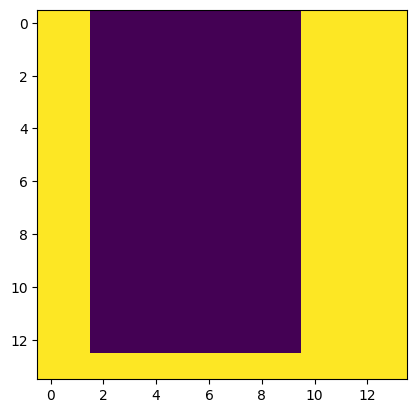

In [43]:
# print(collated_batch, collated_masks_enc, collated_masks_pred)
# print(collated_batch) # tensor([0, 1, 2, 3]) batch
# print(collated_masks_enc) # nenc*[M*[pred mask blocks patch ind]]
# print(collated_masks_pred) # npred * [M * [context]]


# print(len(collated_masks_enc[0]), len(collated_masks_pred[0]))
# print(collated_masks_enc[0], collated_masks_pred[0])

h,w=14,14
img = torch.ones(h*w)
# img[collated_masks_enc[0]]=0
img[collated_masks_pred[0][2]]=0

import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(npimg)
    plt.show()

imshow(img.reshape(h,w))


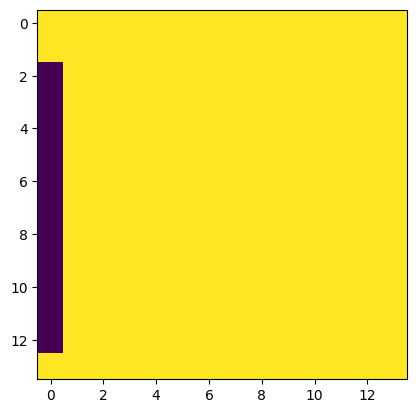

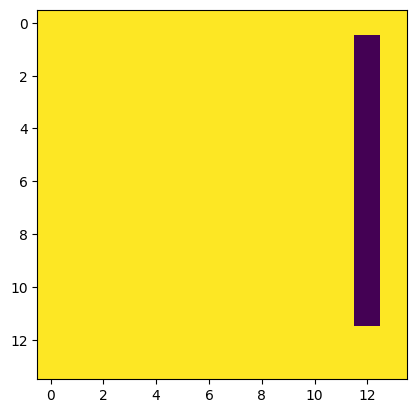

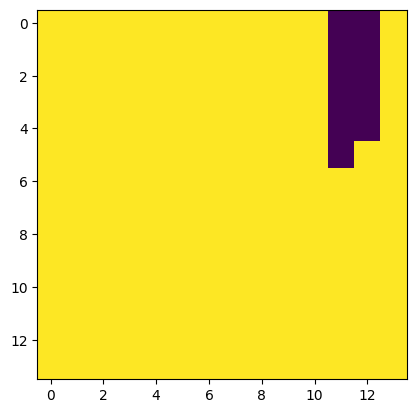

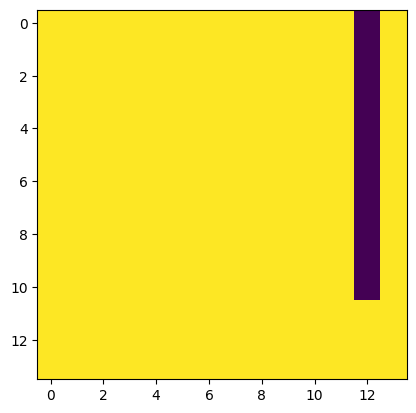

In [47]:

# for masks in collated_masks_pred:
#     for mask in masks:
#         img = torch.ones(h*w)
#         img[mask]=0
#         imshow(img.reshape(h,w))


for masks in collated_masks_enc:
    for mask in masks:
        img = torch.ones(h*w)
        img[mask]=0
        imshow(img.reshape(h,w))


In [ ]:
# for param in seq_jepa.context_encoder.parameters():
#     print(param.requires_grad)

False


In [ ]:
# context_encoder = TransformerModel(d_model, d_model, out_dim=out_dim, nhead=4, nlayers=2, dropout=0.)
# self.predicter = TransformerModel(out_dim, d_model//2, out_dim, nhead=4, nlayers=1, dropout=0.)
# self.target_encoder
print(sum(p.numel() for p in seq_jepa.target_encoder.parameters() if p.requires_grad)) # 59850
# https://openreview.net/pdf?id=MO1OLAKcsJ


47344


In [ ]:
# @title test multiblock mask
def multiblock(seq, min_s, max_s, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_len = torch.rand(1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_pos = torch.rand(M) * (1 - mask_len) # in (0, 1 - mask_len)
    mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
    # mask_len, mask_pos = mask_len * seq, mask_pos * seq
    indices = torch.arange(seq).unsqueeze(0) # [1, seq]
    target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [M, seq]
    return target_mask


seq=400
M=4

# target_mask = multiblock(M, seq, min_s=0.15, max_s=0.2, M=1) # mask out targets to be predicted # [4*batch, seq]
# context_mask = ~multiblock(1, seq, min_s=0.85, max_s=1., M=1)|target_mask.reshape(M,seq).any(0) # [batch, seq]


target_mask = multiblock(seq, min_s=0.15, max_s=0.2, M=4) # mask out targets to be predicted # [4*batch, seq]
context_mask = ~multiblock(seq, min_s=0.85, max_s=1., M=1)|target_mask.reshape(M,seq).any(0) # [batch, seq]

# target_mask, context_mask = target_mask.to(device), context_mask.to(device)

# print(target_mask)
# print(context_mask)

print(target_mask.sum(-1))
print(context_mask.sum(-1))


# sorted_mask, ids = context_mask.sort(dim=1, stable=True)
# indices = ids[~sorted_mask]#.reshape(M,-1) # int idx [num_context_toks] , idx of context not masked
# sorted_x = x[torch.arange(batch).unsqueeze(-1), indices] # [batch, seq-num_trg_toks, dim]
# print(indices)
# print(x)
# print(sorted_x)



# sorted_mask, ids = target_mask.sort(dim=1, descending=False, stable=True)
# # print(sorted_mask, ids)
# indices = ids[~sorted_mask].reshape(M,-1) # int idx [M, seq-num_trg_toks] , idx of target not masked
# print(indices)
# batch=3
# dim=2
# # indices = indices.expand(batch,-1,-1)
# # x = torch.arange(batch*seq).reshape(batch,seq).to(device)
# x = torch.rand(batch, seq, dim)
# print(x)
# sorted_x = x[torch.arange(batch)[...,None,None], indices]
# print(sorted_x.shape) # [batch, M, seq-num_trg_toks, dim]
# print(sorted_x)



tensor([73, 73, 73, 73])
tensor([248])


In [7]:
class Classifier(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super().__init__()
        self.classifier = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.classifier(x)
classifier = Classifier(16).to(device)
# coptim = torch.optim.AdamW(classifier.parameters(), lr=1e-3)
coptim = torch.optim.SGD(classifier.parameters(), lr=1e-4)

In [ ]:
# print(seq_jepa.classifier.weight[0])
# for n, p in seq_jepa.target_encoder.named_parameters():
#     print(n,p)
optim.param_groups[0]['lr'] = 1e-5


In [ ]:
# @title test multiblock params
import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# dataiter = iter(train_data)
img,y = next(dataiter)
img = img.unsqueeze(0)
b,c,h,w = img.shape
img = img.flatten(2).transpose(-2,-1).to(torch.bfloat16) # [b,c,h,w] -> [b,h*w,c]
print(img.shape)
batch, seq,_ = img.shape
M=4
target_mask = multiblock(seq, min_s=0.15, max_s=0.2, M=M) # mask out targets to be predicted # [M, seq]
context_mask = ~multiblock(seq, min_s=0.85, max_s=1., M=1)|target_mask.reshape(M,seq).any(0) # [1, seq], True->Mask
target_mask, context_mask = target_mask.to(device), context_mask.to(device)
# print(target_mask, context_mask)


# print(target_mask.shape, context_mask.shape)
# target_img, context_img = img*target_mask.unsqueeze(-1), img*context_mask.unsqueeze(-1)
target_img, context_img = img*~target_mask.unsqueeze(-1), img*~context_mask.unsqueeze(-1)
# print(target_img.shape, context_img.shape)
target_img, context_img = target_img.transpose(-2,-1).reshape(M,c,h,w), context_img.transpose(-2,-1).reshape(b,c,h,w)
target_img, context_img = target_img.float(), context_img.float()

# imshow(out.detach().cpu())
imshow(target_img[0])
imshow(context_img[0])


In [12]:
# @title strain ctrain test
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler()

def strain(model, dataloader, optim, scheduler=None): # train function with automatic mixed precision
# def strain(model, train_iter, optim, scheduler=None): # train function with automatic mixed precision
    model.train()
    for i, (img, _) in enumerate(dataloader):
    # for i in range(50):
    #     try: img, _ = next(train_iter)
    #     except StopIteration:
    #         train_iter = iter(train_loader)
    #         img, _ = next(train_iter)

        img = img.to(device) # [batch, ]
        img = img.flatten(2).transpose(-2,-1)#.to(torch.bfloat16) # [b,c,h,w] -> [b,h*w,c]
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            loss = model.loss(img)

        optim.zero_grad()
        # print(loss)
        scaler.scale(loss).backward()

        # total_norm = 0
        # for p in model.parameters(): total_norm += p.grad.data.norm(2).item() ** 2
        # total_norm = total_norm**.5
        # print('total_norm', total_norm)
        # for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        #     print(p.grad.data.norm(2).item())
        scaler.unscale_(optim)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # 0.5

        scaler.step(optim)
        scaler.update()
        # loss.backward()
        # optim.step()
        # model.target_encoder.update_parameters(model.context_encoder)
        # # update_bn(dataloader, model.target_encoder)
        # update_bn(train_iter, model.target_encoder)


        with torch.no_grad():
            m=0.99 # m = next(momentum_scheduler)
            for param_q, param_k in zip(model.context_encoder.parameters(), model.target_encoder.parameters()):
                param_k.data.mul_(m).add_((1.-m) * param_q.detach().data)


        # if scheduler is not None: scheduler.step()
        print("strain",loss.item())
        # for param in seq_jepa.context_encoder.cls: print(param.data)
        # for param in seq_jepa.predicter.cls: print(param.data)
        try: wandb.log({"loss": loss.item()})
        except NameError: pass
        # if i >= 50: break
    return train_iter


# def ctrain(model, classifier, dataloader, coptim, scheduler=None): # train function with automatic mixed precision
def ctrain(model, classifier, train_iter, coptim, scheduler=None): # train function with automatic mixed precision
    model.eval()
    classifier.train()
    # for i, (img, y) in enumerate(dataloader):
    for i in range(10):
        try: img, y = next(train_iter)
        except StopIteration:
            train_iter = iter(train_loader)
            img, y = next(train_iter)
        # print("ctrain",y)
        img, y = img.to(device), y.to(device) # [batch, ]
        # img = img.flatten(start_dim=1)
        img = img.flatten(2).transpose(-2,-1).to(torch.bfloat16)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            with torch.no_grad():
                sx = model(img).detach()
            # print(sx[0][0])
            y_ = classifier(sx)
            loss = F.cross_entropy(y_, y)
        # print(classifier.classifier.weight[0])
        # print(y_.shape, y.shape)
        # print(loss)
        coptim.zero_grad()
        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # .5
        scaler.step(coptim)
        scaler.update()
        print("classify",loss.item())
        try: wandb.log({"closs": loss.item()})
        except NameError: pass
        # if i >= 10: break
    return train_iter


# def test(model, dataloader):
def test(model, classifier, test_iter):
    model.eval()
    classifier.eval()
    # for i, (img, y) in enumerate(dataloader):
    for i in range(10):
        try: img, y = next(test_iter)
        except StopIteration:
            test_iter = iter(test_loader)
            img, y = next(test_iter)
        # print("test",y)

        img, y = img.to(device), y.to(device) # [batch, ]
        # img = img.flatten(start_dim=1).to(torch.bfloat16)
        img = img.flatten(2).transpose(-2,-1)#.to(torch.bfloat16)

        with torch.no_grad():
            sx = model(img)
            y_ = classifier(sx)
        correct = (y==y_.argmax(dim=1)).sum().item()
        print(correct/len(y))
        try: wandb.log({"correct": correct/len(y)})
        except NameError: pass
        # if i >= 10: break
    return test_iter

train_iter = iter(train_loader)
test_iter = iter(test_loader)
for i in range(100):
    # strain(seq_jepa, train_loader, optim)
    # ctrain(seq_jepa, classifier, train_loader, coptim)
    # test(seq_jepa, test_loader)

    train_iter = strain(seq_jepa, train_iter, optim)
    train_iter = ctrain(seq_jepa, classifier, train_iter, coptim)
    test_iter = test(seq_jepa, classifier, test_iter)


strain 1.1552958488464355
strain 1.0704407691955566
strain 0.9711266160011292
strain 0.9005165100097656
strain 0.8340376615524292
strain 0.7421780824661255
strain 0.6472571492195129
strain 0.6140769124031067
strain 0.5460553169250488
strain 0.505041778087616
strain 0.4577639400959015
strain 0.42256808280944824
strain 0.39006826281547546
strain 0.35492464900016785
strain 0.3293170630931854
strain 0.29724881052970886
strain 0.29417821764945984
strain 0.25827911496162415
strain 0.23480743169784546
strain 0.23319143056869507
strain 0.2108106166124344
strain 0.18544282019138336
strain 0.1860089898109436
strain 0.1739669144153595
strain 0.153715118765831
strain 0.15700477361679077
strain 0.13227126002311707
strain 0.13519373536109924
strain 0.12162256240844727
strain 0.11306873708963394
strain 0.11244712769985199
strain 0.10203242301940918
strain 0.09124936163425446
strain 0.09037154912948608
strain 0.08320996910333633
strain 0.0772230476140976
strain 0.07183892279863358
strain 0.06892077624

KeyboardInterrupt: 

In [ ]:
# for param in seq_jepa.context_encoder.cls: print(param.data)
print(seq_jepa.context_encoder.cls.is_leaf)

True


In [ ]:
# seq=40
# src = seq_jepa.context_encoder.pos_encoder(torch.arange(seq, device=device))
# for x in src:
#     print(x)
print(.999**50)


In [ ]:
# @title save/load
# from google.colab import drive
# drive.mount('/content/drive')
# folder='/content/drive/MyDrive/jepa/'

# modelsd, optimsd = torch.load(folder+'SeqJEPA.pkl', map_location=device).values()
modelsd, optimsd = torch.load('SeqJEPA.pkl', map_location=device).values()
seq_jepa.load_state_dict(modelsd, strict=False)
optim.load_state_dict(optimsd)

<ipython-input-6-45af7927d988>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelsd, optimsd = torch.load('SeqJEPA.pkl', map_location=device).values()


In [ ]:
checkpoint = {'model': seq_jepa.state_dict(), 'optimizer': optim.state_dict()}
# # torch.save(checkpoint, folder+'SeqJEPA.pkl')
torch.save(checkpoint, 'SeqJEPA.pkl')

In [11]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="SeqJEPA", config={"model": "res18",})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


closs,▄▃▅▃▄▆▅▂▅██▂▅▂▄▅▇▅▃▆▆▄▆▅▅▅▆▅▁▃▆▅▄▅▅▃▆▆▄▃
correct,▅▁▄▄▂▆▄▆▅▁▄▂▆▆▄▅▂▃▅▁▅▃▁▂▄▆▅▃▅▂▆▃▃▂▄▅█▅▅▃
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
closs,2.81348
correct,0.08594
loss,0.0001


In [ ]:
x = torch.rand(4,100,3)

x=x.transpose(-2,-1) # [batch, dim, seq]
 # in, out, kernel, stride, pad
# net = nn.Conv1d(3,16,7,2,7//2)
net = nn.Sequential(nn.Conv1d(3,16,7,2,7//2), nn.MaxPool1d(3, 2, 3//2))
# net = nn.Conv1d(3,16,(7,3),2,3//2)
out = net(x)
print(out.shape)

torch.Size([4, 16, 25])


In [ ]:
# @title test repeat_interleave
# x = torch.rand(3,5)
x = torch.rand(3,5,7)
print(x)
# out = x.repeat(2,1) # [2*3,5]
# print(out)
# x_ = out.reshape(2,3,5)
# print(x_)
# out = x.repeat_interleave(2,1,1) # [3*2,5]
out = x.repeat_interleave(2,dim=0) # [3*2,5]
# print(out)
# x_ = out.reshape(2,3,5,7)
x_ = out.reshape(3,2,5,7)
print(x_)


# batch=1
# seq_len=5
# dim=4
# positional_emb = torch.rand(batch, seq_len, dim)
# print(positional_emb)
# num_tok=2
# trg_indices=torch.randint(0,seq_len,(M, num_tok))
# print(trg_indices)
# # pos_embs = positional_emb.gather(1, trg_indices.unsqueeze(0))
# pos_embs = positional_emb[torch.arange(batch)[...,None,None],trg_indices.unsqueeze(0)]
# # pos_embs = positional_emb[0,trg_indices]
# # [batch, M, num_tok, dim]
# print(pos_embs.shape)
# print(pos_embs)


In [ ]:
# @title test ropes
# for i, (img, _) in enumerate(test_loader):
#     break
# print(img.shape) # [batch, 1, 28, 28]
# print(img[0]) # [0,1)
d_model=8
# rot_emb = RotEmb(d_model, top=torch.pi, base=10)
# x = torch.linspace(0,1,20)
# out = rot_emb(x)
# print(out.shape)
# print(out)

# # pos_encoder = RoPE(d_model, seq_len=15, base=100)
# pos_encoder = RoPE(d_model, seq_len=15, base=10000)
x = torch.ones(1, 10, d_model)
# # x = torch.ones(1, 10, d_model)
# out = pos_encoder(x)
# # print(out.shape)
# for x in out[0]:
#     print(x)


# pos_encoder = LearnedRoPE(d_model, seq_len=512)
# out = pos_encoder(x)
# for o in out[0]:
#     print(o)

# pos_encoder.weights = nn.Parameter(torch.randn(1, d_model//2))
# out = pos_encoder(x)
# for o in out[0]:
#     print(o)


# tensor([-0.0177, -0.9998,  0.8080, -0.5892, -0.7502, -0.6612,  0.3885,  0.9214])


In [ ]:
# @title SeqJEPA
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema
device = "cuda" if torch.cuda.is_available() else "cpu"

def multiblock(batch, seq, min_s, max_s, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
        mask_len = torch.rand(batch, M) * (max_s - min_s) + min_s # in (min_s, max_s)
        mask_pos = torch.rand(batch, M) * (1 - mask_len) # in (0, 1 - mask_len)
        mask_len, mask_pos = mask_len * seq, mask_pos * seq
        indices = torch.arange(seq)[None,None,...]
        target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [batch, M, seq]
        target_mask = target_mask.any(1) # True -> masked # multiblock masking # [batch, seq]
        return target_mask



class SeqJEPA(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, num_layers=1):
        super().__init__()
        self.in_dim = in_dim
        # if out_dim is None: self.out_dim = in_dim
        if out_dim is None: out_dim = d_model
        self.num_layers = num_layers
        self.d_model = d_model
        act = nn.GELU() # ReLU GELU SiLU

        dim=8


        self.calorie_emb = RotEmb(dim, top=1, base=10) # 0-4
        self.steps_emb = RotEmb(dim, top=1, base=10) # 0-5
        self.enc0 = nn.Sequential(
            nn.Linear(dim*2, d_model), act,
            nn.Linear(d_model, d_model), act,
        )
        self.hour_emb = CircularEmb(dim, torch.pi/2) # circular (0,1) # 0-24
        self.temp_emb = RotEmb(dim, top=1/3, base=10) # 18-35
        self.heart_emb = RotEmb(dim, top=1/3, base=100) # 50-200
        self.enc1 = nn.Sequential(
            nn.Linear(dim*3, d_model), act,
        )

        # self.transformer = TransformerClassifier(d_model, out_dim=out_dim, nhead=8, nlayers=2)
        # # self.fc = nn.Linear(d_model, out_dim)
        self.context_encoder = TransformerModel(d_model, out_dim=out_dim, nhead=8, nlayers=2, dropout=0.)
        self.predicter = TransformerModel(out_dim, nhead=8, nlayers=1, dropout=0.)
        self.target_encoder = AveragedModel(self.context_encoder, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    def loss(self, hr, temp, heart): # [batch, 1+T]
        # batch = hr.size(0)
        res_id, activeKilocalories, steps = hr[:,0], temp[:,0], heart[:,0]
        # enc_summary = self.enc0(torch.cat([self.calorie_emb(activeKilocalories), self.steps_emb(steps)], dim=-1)) # [batch, d_model]
        enc_summary = self.enc0(torch.cat([self.calorie_emb(torch.log(activeKilocalories.clamp(min=1))), self.steps_emb(torch.log(steps.clamp(min=1)))], dim=-1)) # [batch, d_model]
        x = self.enc1(torch.cat([self.hour_emb(hr[:,1:]/24), self.temp_emb(temp[:,1:]), self.heart_emb(heart[:,1:])], dim=-1)) # [batch, T, d_model]
        # print('violet fwd', hr.shape, enc_summary.shape, x.shape)

        # # mask=(torch.rand(self.seq_len)<.1) # True -> masked # random masking
        # mask=(torch.rand_like(x)<.1) # True -> masked # random masking

        # patches pad -enc> patch_enc
        # rearrange patch in padded/masked, -pred> pred of masked
        # mse tgt_enc(img)

        # average L2 distance between the predicted patch-level representations sˆy(i) and the target patch-level representation sy(i);
        # F.smooth_l1_loss

        batch, seq, dim = x.shape

        # mask=(torch.rand(batch, seq)<.75) # True -> masked # random masking
        # sorted_mask, ids = mask.sort(dim=1)
        # # sorted_x = x[torch.arange(batch)[...,None,None],ids]
        # sorted_x = x[torch.arange(batch).unsqueeze(-1),ids]
        # sorted_mask = torch.cat([torch.zeros((batch, 1), dtype=torch.bool), sorted_mask], dim=1) # True->mask
        # sorted_x = torch.cat([enc_summary.unsqueeze(1), sorted_x], dim=1)
        # sorted_sx = self.context_encoder(sorted_x, src_key_padding_mask=sorted_mask)
        # # torch.zeros_like(sorted_sx)
        # sx = sorted_sx[torch.arange(batch).unsqueeze(-1),ids.argsort(1)]
        # sy_ = self.predicter(sx, src_key_padding_mask=mask)
        # sy = self.target_encoder(x)*~mask


        # target_mask = multiblock(batch, seq, min_s=0.15, max_s=0.2, M=4)
        # context_mask = ~multiblock(batch, seq, min_s=0.85, max_s=1., M=1)|target_mask
        # sx = self.context_encoder(x, src_key_padding_mask=context_mask)
        # sy_ = self.predicter(sx, cls_mask=target_mask)*target_mask.unsqueeze(-1)
        # sy_ = self.predicter(sx, cls_mask=target_mask)
        # # print(sy_.shape, target_mask.shape)
        # sy = self.target_encoder(x)*target_mask.unsqueeze(-1)


        M=4
        target_mask = multiblock(M*batch, seq, min_s=0.15, max_s=0.2, M=1) # mask out targets to be predicted # [4*batch, seq]
        context_mask = ~multiblock(batch, seq, min_s=0.85, max_s=1., M=1)|target_mask.reshape(batch,M,seq).any(1) # [batch, seq]


        x = torch.cat([enc_summary.unsqueeze(1), x], dim=1) # [batch, 1+T, d_model]
        target_mask = torch.cat([torch.zeros((M*batch, 1), dtype=bool), target_mask],dim=1) # [4*batch, 1+T]
        context_mask = torch.cat([torch.zeros((batch, 1), dtype=bool), context_mask],dim=1) # [batch, 1+T]

        # x = x.repeat(4,1,1)
        # context_mask = context_mask.repeat(4,1)
        sx = self.context_encoder(x, src_key_padding_mask=context_mask).repeat(M,1,1)
        sy_ = self.predicter(sx, cls_mask=target_mask)*target_mask.unsqueeze(-1)
        # sy_ = self.predicter(sx, cls_mask=target_mask)
        # print(sy_.shape, target_mask.shape)
        sy = self.target_encoder(x).repeat(M,1,1)*target_mask.unsqueeze(-1)

        loss = F.smooth_l1_loss(sy, sy_)
        return loss

    # def forward(self, hr, temp, heart): # [batch, 1+T]
    #     # batch = hr.size(0)
    #     # batch, seq, dim = x.shape
    #     res_id, activeKilocalories, steps = hr[:,0], temp[:,0], heart[:,0]
    #     enc_summary = self.enc0(torch.cat([self.calorie_emb(activeKilocalories), self.steps_emb(steps)], dim=-1)) # [batch, d_model]
    #     x = self.enc1(torch.cat([self.hour_emb(hr[:,1:]/24), self.temp_emb(temp[:,1:]), self.heart_emb(heart[:,1:])], dim=-1)) # [batch, T, d_model]

    #     x = torch.cat([enc_summary.unsqueeze(1), x], dim=1)
    #     # sx = self.context_encoder(x)
    #     sx = self.target_encoder(x)
    #     out = sx.mean(dim=1)
    #     return out



seq_jepa = SeqJEPA(in_dim=16, d_model=32, out_dim=16, num_layers=1).to(device)#.to(torch.float)
soptim = torch.optim.AdamW(seq_jepa.parameters(), lr=1e-3)



In [ ]:
# @title ijepa vision_transformer.py
# https://github.com/facebookresearch/ijepa/blob/main/src/models/vision_transformer.py
import math
from functools import partial
import numpy as np
import torch
import torch.nn as nn

from src.utils.tensors import (trunc_normal_, repeat_interleave_batch)

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=float)
    grid_w = np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)
    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product
    emb = np.concatenate([np.sin(out), np.cos(out)], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class ConvEmbed(nn.Module):
    """3x3 Convolution stems for ViT following ViTC models"""
    def __init__(self, channels, strides, img_size=224, in_chans=3, batch_norm=True):
        super().__init__()
        # Build the stems
        stem = []
        channels = [in_chans] + channels
        for i in range(len(channels) - 2):
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=strides[i], padding=1, bias=(not batch_norm))]
            if batch_norm:
                stem += [nn.BatchNorm2d(channels[i+1])]
            stem += [nn.ReLU(inplace=True)]
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)


# https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
def apply_masks(x, masks):
    """:param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep"""
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1)) # [batch,T,dim]
        all_x += [torch.gather(x, dim=1, index=mask_keep)] # M * [batch,mask_size,dim]
    return torch.cat(all_x, dim=0)  # [M*batch,mask_size,dim]


class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(self, num_patches, embed_dim=768, predictor_embed_dim=384,
        depth=6, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02, **kwargs):
        super().__init__()
        self.init_std = init_std
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim), requires_grad=False)
        predictor_pos_embed = get_2d_sincos_pos_embed(self.predictor_pos_embed.shape[-1], int(num_patches**.5), cls_token=False)
        self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0)) # [1, num_patches, predictor_embed_dim]
        # --
        self.predictor_blocks = nn.ModuleList([Block(dim=predictor_embed_dim, num_heads=num_heads, drop=drop_rate, drop_path=dpr[i]) for i in range(depth)])
        self.predictor_norm = nn.LayerNorm(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        # trunc_normal_(self.mask_token, std=self.init_std)

    def forward(self, x, masks_x, masks):
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'
        if not isinstance(masks_x, list): masks_x = [masks_x]
        if not isinstance(masks, list): masks = [masks]

        # -- Batch Size
        B = len(x) // len(masks_x)

        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x) # [batch, num_patches, predictor_embed_dim]

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1) # [batch, num_patches, predictor_embed_dim]
        x += apply_masks(x_pos_embed, masks_x)

        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1)
        pos_embs = apply_masks(pos_embs, masks)
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x))
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1)
        # --
        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, embed_dim=768, predictor_embed_dim=384, depth=12, predictor_depth=12,
        num_heads=12, mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_std=0.02, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.init_std = init_std
        # --
        self.patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

    def forward(self, x, masks=None):
        if masks is not None:
            if not isinstance(masks, list): masks = [masks]

        x = self.patch_embed(x)
        B, N, D = x.shape # [batch, T, d_model]

        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        if masks is not None: x = apply_masks(x, masks)

        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None: x = self.norm(x)
        return x

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N: return pos_embed
        class_emb, pos_embed = pos_embed[:, 0], pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2), scale_factor=math.sqrt(npatch / N), mode='bicubic',)
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)

# from functools import partial
# def vit_predictor(**kwargs):
#     model = VisionTransformerPredictor(
#         mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     return model

def vit(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, # tiny
        # patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, # small
        # patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, # base
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

